## Using NLP to Analyse Data Science Articles in Medium to Uncover Topics and Predict Audience Engagement

##### By: David Bender for Springboard Course (May 2020 cohort) | email: [bender2242@gmail.com](mailto:bender2242@gmail.com)

###### This notebook is intended to help those who are interested in popular and emerging topics in data science, as well as provide some analysis that may be useful if you are thinking about writing your own data science blog posts or articles. Consider it a meta-analysis of data science topics and tactics, taken from authors who have published on the popular blogging site Medium. I will be using several approaches for natural language processing (NLP) including both supervised and unsupervised models to analyse the articles.


### STAGE 1: Import the dataset of Medium articles and explore the data

##### This data is available on Kaggle: [click here](https://www.kaggle.com/hsankesara/medium-articles)

>#### Step 1: Import the required packages and data
>#### Step 2: Using custom modules to clean and explore the data
>#### Step 3: Remove outliers
>#### Step 4: Process the data for text analysis
>#### Step 5: Check the language of the text, keeping only English articles
>#### Step 6: Extract organisations mentioned in the text, using spaCy's Natural Entity Recognition

---

## STAGE 2: Using NLP tools and approaches to analyse the text, including visualising the topics and phrases in the articles and predicting the number of claps that an article or title might receive from the Medium community.

#### Approach 1: scikit-learn prediction for number of claps, using the text of the articles

scikit-learn models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer

#### Approach 2: Analysing the text using word vectors, and predicting the number of claps 

Models/Packages:
- spaCy: word vector's (pre-trained on Wikipedia corpus)
- sklearn: RandomForestRegressor, KNearestRegressor

#### Approach 3: Analysing the topics and entities in the articles using unsupervised topic modelling and clustering

Models/Packages:
- sklearn: t-SNE
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

#### Bonus: A 'clap predictor' for new titles, based on the best performing models from above

In [70]:
## Import the required packages. Also available to install via the requirements.txt file in the project folder

# Standard python packages
import pandas as pd

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#nltk.download('words') # Use for English language corpus
#nltk.download('punkt') # Download for sentence and word tokenization

# Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow
from tensorflow import keras

# Custom module
#%load_ext autoreload
%autoreload 2
%aimport article_analysis

In [71]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-05-10T15:03:05+01:00

CPython 3.7.3
IPython 7.14.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit


### STAGE 1: Import the dataset of Medium articles and explore the data

In [72]:
articles = pd.read_csv('../data/data.csv').dropna()
articles.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


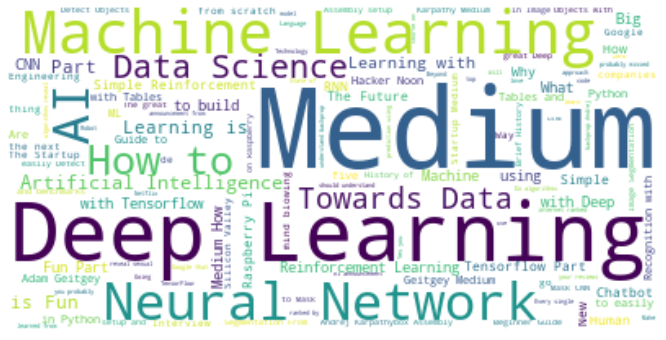

In [73]:
## We can import the custom module to run some data cleaning and analysis
from article_analysis.data import ArticleDataset

# We create the custom object ArticleDataset to run our data exploration and cleaning functions
analysis = ArticleDataset(articles)

# A wordcloud to understand the general topics in the text of the dataset
analysis.generate_wordcloud(articles.title)

In [74]:
## For this particular dataset, we need to perform some basic data cleaning on some of the columns

# Format claps from string into integer
claps_number = []
for clap in articles.claps:
    if 'K' in str(clap):
        clap_num = clap[:-1]
        clap_num = float(clap_num) * 1000
        claps_number.append(int(clap_num))
    else:
        claps_number.append(clap)
        
articles['claps'] = [int(x) for x in claps_number] # Convert the claps column into the formatted number
filtered_columns = ['author','claps','title','text'] # Select columns in dataframe
articles = articles[filtered_columns]
articles = articles.drop_duplicates().reset_index(drop=True) # some duplicate articles were in the dataset
articles.head()

,author,claps,title,text
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


#### Outlier values in the claps count will likely be an issue, so we will create a function to identify and visualise these examples

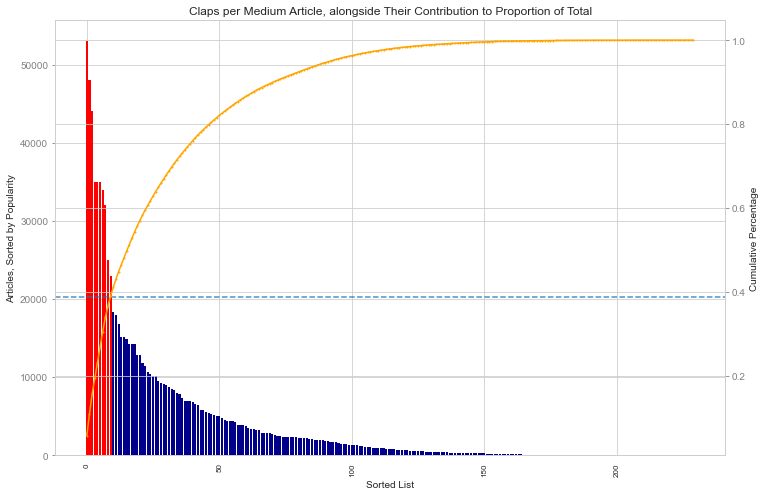

The articles to exclude are:

1 - How Does Spotify Know You So Well? – Member Feature Stories – Medium: 53000 claps.
2 - I interviewed at five top companies in Silicon Valley in five days, and luckily got five job offers: 48000 claps.
3 - Blockchain is not only crappy technology but a bad vision for the future: 44000 claps.
4 - The impossibility of intelligence explosion – François Chollet – Medium: 35000 claps.
5 - Software 2.0 – Andrej Karpathy – Medium: 35000 claps.
6 - Machine Learning is Fun! – Adam Geitgey – Medium: 35000 claps.
7 - Artificial Intelligence — The Revolution Hasn’t Happened Yet: 34000 claps.
8 - A Beginner’s Guide to AI/ML 🤖👶 – Machine Learning for Humans – Medium: 32000 claps.
9 - Artwork Personalization at Netflix – Netflix TechBlog – Medium: 25000 claps.
10 - Understanding Hinton’s Capsule Networks. Part I: Intuition.: 23000 claps.

The dataset now has 220 articles at this stage.


In [75]:
## We will apply one of our custom functions from the imported module to visualise the outliers
outliers = analysis.exclude_outliers(articles.claps, negatives=False, rounded=0)

# The 'outliers' variable will return four values for upper and lower bounds and specified n-values at top and bottom.
# We are interested exclusively in the upper values.
upper_claps = outliers[0]
lower_claps = outliers[1]
n_upper = outliers[2]

analysis.make_paretto_chart(dataframe=articles, 
                            column_name='claps', 
                            cutoff=upper_claps, 
                            n_top=n_upper,
                            title='Claps per Medium Article, alongside Their Contribution to Proportion of Total')


## Now we can filter the articles dataset by removing the outliers
articles = articles[(articles.claps < upper_claps) & (articles.claps > lower_claps)].reset_index(drop=True)
print('\nThe dataset now has {} articles at this stage.'.format(len(articles)))

#### Next, we will preprocess the text for analysis

##### We can do this by importing an object and its function that will allow us to specify which preprocessing steps we would like to perform

In [76]:
from article_analysis.data import TextProcessing

# This custom object has several text preprocessing steps that you can use, including identifying the language of the text
articles['preprocessed_text'] = [TextProcessing.preprocess_text(article, stop_words=True, lemmatize=False)[0] for article in articles.text ]
articles['language'] = [TextProcessing.preprocess_text(article, stop_words=True, lemmatize=False)[1] for article in articles.text ]

# We will also use spaCy's entity recognition function to extract all of the Organizations that are mentioned, 
# which we will use later when topic modelling and predicting popularity.
articles['organizations_mentioned'] = [TextProcessing.list_of_entities(article) for article in articles.text]

## Now let's take a look at the full dataset that we will be using, after processing steps, removing duplicates, and keeping only English articles
articles = articles[articles.language == 'en'].reset_index(drop=True)
articles

,author,claps,title,text,preprocessed_text,language,organizations_mentioned
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...,en,"[the Mobile World Congress 2017, Lyft, GrowthB..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...,en,"[StackOverflow, Pandas, SQL, Merge, DataFrame,..."
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...,en,"[TPOT, algorithm, Python, GitHub, Pandas, Pyth..."
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...,en,"[A.I., Brilliant.org, the Artificial Neural Ne..."
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...,en,"[Artificial Intelligence, the Insight Artifici..."
...,...,...,...,...,...,...,...
209,Max Pechyonkin,3400,Stochastic Weight Averaging — a New Way to Get...,"In this article, I will discuss two interestin...",article discuss two interesting recent papers ...,en,"[Kaggle, algorithm, SGD, FGE, SWA, PyTorch, Li..."
210,Eugenio Culurciello,2800,"Artificial Intelligence, AI in 2018 and beyond...",These are my opinions on where deep neural net...,opinions deep neural network machine learning ...,en,"[smart homes, the de-facto tool, Attention, FW..."
211,Devin Soni,5800,"Spiking Neural Networks, the Next Generation o...",Everyone who has been remotely tuned in to rec...,everyone remotely tuned recent progress machin...,en,"[CNN, IBM, TrueNorth]"
212,Carlos E. Perez,3900,Surprise! Neurons are Now More Complex than We...,One of the biggest misconceptions around is th...,one biggest misconceptions around idea deep le...,en,"[Artificial Neural Networks, ANN, IBM TrueNort..."


In [77]:
## You can also export this dataframe for use in the future, to save time
path = '../data/processed_data.csv'
articles.to_csv(path)

# And retrieve it here...
articles = pd.read_csv(path, index_col=0)

In [78]:
articles

,author,claps,title,text,preprocessed_text,language,organizations_mentioned
0,Justin Lee,8300,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",oh headlines blared chatbots next big thing ho...,en,"['the Mobile World Congress 2017', 'Lyft', 'Gr..."
1,Conor Dewey,1400,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,youve ever found looking question concept synt...,en,"['StackOverflow', 'Pandas', 'SQL', 'Merge', 'D..."
2,William Koehrsen,2800,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,machine learning increasingly moving handdesig...,en,"['TPOT', 'algorithm', 'Python', 'GitHub', 'Pan..."
3,Gant Laborde,1300,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,understanding ai machine learning big question...,en,"['A.I.', 'Brilliant.org', 'the Artificial Neur..."
4,Emmanuel Ameisen,935,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,want learn applied artificial intelligence lea...,en,"['Artificial Intelligence', 'the Insight Artif..."
...,...,...,...,...,...,...,...
209,Max Pechyonkin,3400,Stochastic Weight Averaging — a New Way to Get...,"In this article, I will discuss two interestin...",article discuss two interesting recent papers ...,en,"['Kaggle', 'algorithm', 'SGD', 'FGE', 'SWA', '..."
210,Eugenio Culurciello,2800,"Artificial Intelligence, AI in 2018 and beyond...",These are my opinions on where deep neural net...,opinions deep neural network machine learning ...,en,"['smart homes', 'the de-facto tool', 'Attentio..."
211,Devin Soni,5800,"Spiking Neural Networks, the Next Generation o...",Everyone who has been remotely tuned in to rec...,everyone remotely tuned recent progress machin...,en,"['CNN', 'IBM', 'TrueNorth']"
212,Carlos E. Perez,3900,Surprise! Neurons are Now More Complex than We...,One of the biggest misconceptions around is th...,one biggest misconceptions around idea deep le...,en,"['Artificial Neural Networks', 'ANN', 'IBM Tru..."


## STAGE 2:

#### Approach 1: Predicting the number of claps, based on article text or titles

Models:
- DummyRegressor (to baseline against random chance)
- CountVectorizer
- TfidfVectorizer
- sklearn: RandomForestRegressor, KNeighborsRegressor

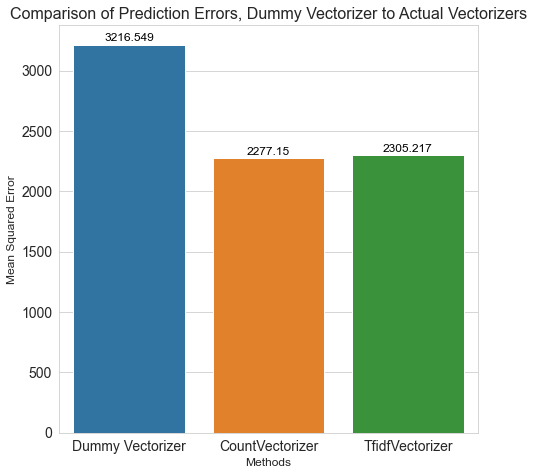

In [79]:
from article_analysis.models import ArticleModeller

# Instantiate the custom object
modeller = ArticleModeller(X=articles.title, y=articles.claps)

# Select Vectorizers
vectorizers = [CountVectorizer, TfidfVectorizer]
vectorizer_names = ['CountVectorizer', 'TfidfVectorizer']

# Select sci-kit learn model for prediction
model = RandomForestRegressor()

# Run the function that combines the dummy vectorizer with our specified vectorizers and visualise the results
modeller.run_dummy_and_vectorizers(vectorizers=vectorizers, model=model, vectorizer_names=vectorizer_names, figsize=(7.5,7.5))

Loading BokehJS ...

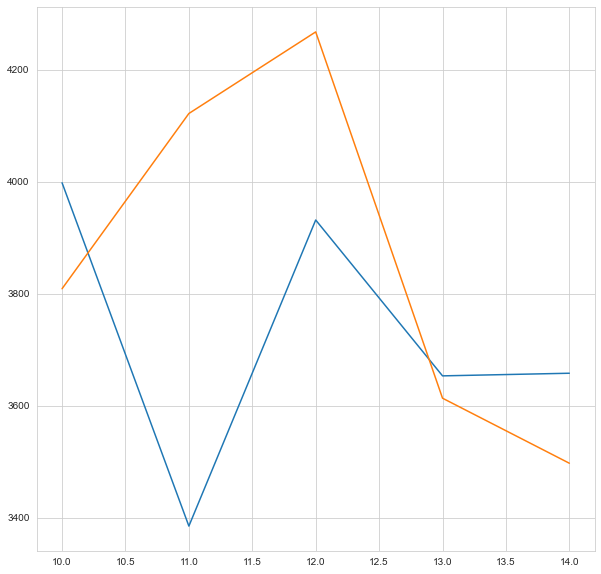

In [101]:
# Applying the same prediction algorith (RandomForestRegressor) using vectors from titles to predict claps

# Establish a range of estimators to test
estimators_range = range(10, 15)

list_of_rmse = []
list_of_mae = []
for estimator in estimators_range:
    model = RandomForestRegressor(n_estimators=estimator)
    root_mse = modeller.sklearn_prediction_with_vectors(model_select=model)[0]
    mae = modeller.sklearn_prediction_with_vectors(model_select=model)[0]
    list_of_rmse.append(root_mse)
    list_of_mae.append(mae)
    
plot_data = pd.DataFrame({'estimators':estimators_range,
                        'root_MSE':list_of_rmse,
                         'MAE':list_of_mae})

plt.figure(figsize=(10,10))
plt.plot(plot_data.estimators, plot_data.root_MSE)
plt.plot(plot_data.estimators, plot_data.MAE)
plt.show()

#### Approach 2: Predicting the number of claps using word vectors

Packages:
- spaCy's Natural Entity Recognition
- sklearn: RandomForestRegressor, KNeighborsRegressor

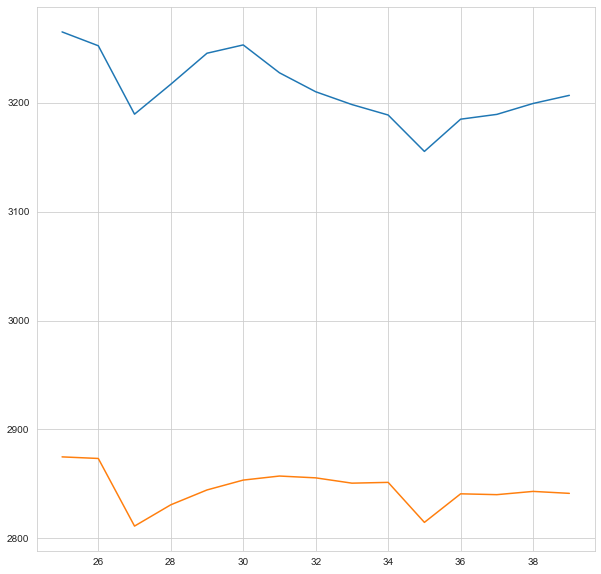

In [100]:
# Next, using K-Nearest Neighbors with titles to predict claps

# Establish a range of estimators to test
neighbors_range = range(25, 40)

list_of_rmse = []
list_of_mae = []
for neighbor in neighbors_range:
    model = KNeighborsRegressor(n_neighbors=neighbor)
    root_mse = modeller.sklearn_prediction_with_vectors(model_select=model)[0]
    mae = modeller.sklearn_prediction_with_vectors(model_select=model)[1]
    list_of_rmse.append(root_mse)
    list_of_mae.append(mae)
    
plot_data = pd.DataFrame({'neighbors':neighbors_range,
                        'root_MSE':list_of_rmse,
                         'MAE':list_of_mae})

plt.figure(figsize=(10,10))
plt.plot(plot_data.neighbors, plot_data.root_MSE, label='Root Mean Squared Error')
plt.plot(plot_data.neighbors, plot_data.MAE, label='Mean Absolute Error')
plt.show()

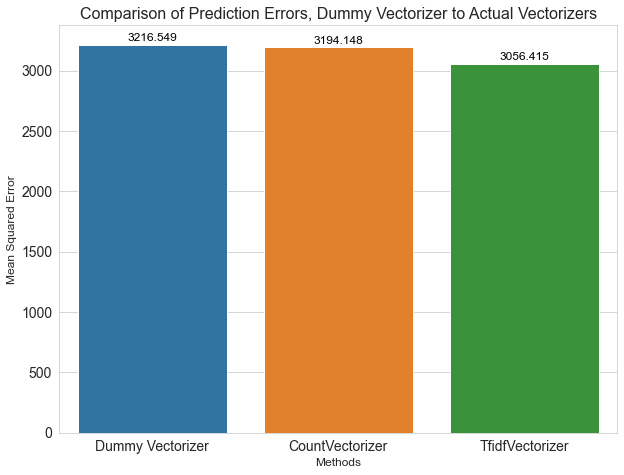

In [82]:
# Lastly, trying a CountVectorizer approach using the organisations that we extracted with the Entity Recognition
# Instantiate the custom object
modeller = ArticleModeller(X=articles.organizations_mentioned, y=articles.claps)

# Select Vectorizers
vectorizers = [CountVectorizer, TfidfVectorizer]
vectorizer_names = ['CountVectorizer', 'TfidfVectorizer']

# Select sci-kit learn model for prediction
model = RandomForestRegressor(25)

# Run the function that combines the dummy vectorizer with our specified vectorizers and visualise the results
modeller.run_dummy_and_vectorizers(vectorizers=vectorizers, model=model, vectorizer_names=vectorizer_names)

#### In terms of prediction accuracy, it looks like the best method is one of the simplest ones, the CountVectorizer method alongside a RandomForestRegressor. However, it is clear that the accuracy is still likely too low for real use - so something to explore in the future.

#### Approach 3: Analysing the topics in the articles using unsupervised topic modelling

Models/Packages:
- sklearn: TSNE and Bokeh for visualisation
- sklearn: Latent Dirichlet Allocation
- pyLDAvis: interactive topic visualisation and analysis tool

In [90]:
from article_analysis.models import TopicModeller

vectors = TopicModeller(dataframe=articles)
vectors.topic_count = 10
vectors.generate_word_vector_plot('organizations_mentioned')

In [89]:
vectors.generate_lda_visualisation(articles.text)

#### BONUS: Building a 'Clap Predictor' for article titles

In [86]:
# Create the input for the new title
title_input = input('What is your title? ')

What is your title? Analysis of Data Science Articles on Medium, using python NLP techniques


In [87]:
# Create a new modeller using the titles from the articles
modeller = ArticleModeller(X=articles.title, y=articles.claps)

# Select a model for prediction
prediction_model = RandomForestRegressor(n_estimators=25)

predicted_claps = modeller.predict_popularity_from_input(title_input, model_select=prediction_model)

# Print the predicted claps
print('That title will receive {:,} claps.'.format(predicted_claps))

That title will receive 3,006 claps.


#### NEXT STEPS: There are clearly plenty of opportunities to extend the methods and approaches used in this analysis, some of them include:

> - Converting the continuous values of 'claps' to categories, and thus converting the prediction from regression to classification. This may make the results more appealing and understandable for users, as well, because the prediction will have more variable and 'forgiveness'.
> - Tool for 'similar articles to yours', using a structure much like the clap predictor above and a nearest neighbors model
> - Using deep learning models, such as keras (within tensorflow) for more accurate prediction
> - Going deeper into entity recognition to extract insights or connections between articles or authors

#### Credit and Acknowledgments

 Ryan McCormack

 [A practitioner's guide to Natural Language Processing Part 1 - DJ Sarkar](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)
 
 [Word Cloud code](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)